## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

np.set_printoptions(suppress=True)

# Load Data

The data for this notebook comes from the [U.S. National Election Day Exit Polls](https://ropercenter.cornell.edu/exit-polls/us-national-election-day-exit-polls).

Here’s a brief description of how exit polls work.

Exit polls are conducted by Edison Research on behalf of a consortium of media organizations.

First, the member organizations decide what races to cover, what sample size they want, what questions should be asks, and other details. Then, sample precincts are selected, and local interviewers are hired and trained. Then, at those precincts, the local interviewer approaches a subset of voters as they exit the polls (for example, every third voter, or every fifth voter, depending on the required sample size).

When a voter is approached, they are asked if they are willing to fill out a questionnaire. Typically about 40-50% agree. (For those that decline, the interviewer visually estimates their age, race, and gender, and notes this information, so that the response rate by demographic is known and responses can be weighted accordingly in order to be more representative of the population.)

Voters that agree to participate are then given an form with 15-20 questions. They fill in the form (anonymously), fold it, and put it in a small ballot box.

Three times during the day, the interviewers will stop, take the questionnaires, compile the results, and call them in to the Edison Research phone center. The results are reported immediately to the media organizations that are consortium members.

In addition to the poll of in-person voters, absentee and early voters (who are not at the polls on Election Day) are surveyed by telephone.

### Download the data and documentation

The exit poll data is not freely available on the web, but is available to those with institutional membership.

1. Open the Study Record for [2020 National Election Day Exit Poll](https://ropercenter.cornell.edu/ipoll/study/31119913).
2. Click on the “Downloads” tab, and then click on the CSV data file in the “Datasets” section of this tab. Press “Accept” to accept the terms and conditions. Find the file `31119913_National2020.csv` in your browser’s default download location.
3. After you download the CSV file, scroll down a bit until you see the “Study Documentation, Questionnaire and Codebooks” PDF file. Download this file as well.


### Load data with pandas

Now, use the `read_csv` function in `pandas` to read in the file.

Also use `head` to view the first few rows of data and make sure that everything is read in correctly.

In [2]:
df = pd.read_csv('31119913_National2020.csv')
df.head()

,id,weight,pres,hou,abort2,abortion,acasupre,age,age3,age10,...,vote2016,voteexpe,voteex_1,votemeth,work,worksex,wprotbrn,wprotb_1,wrkwomen,wrkwom_1
0,152520,0.206209,Did not vote,,Omit,Omit,,45-64,30-59,45-49,...,,,,Election day,,,No,,,
1,142428,0.209581,Did not vote,,,,,18-29,18-29,18-24,...,,,,Election day,,,,,,
2,117340,0.016127,Joe Biden,,,,Keep it as is,65+,60+,65-74,...,,,,By mail,,,,,,
3,115688,0.019268,Joe Biden,,Legal,Legal in all cases,,65+,60+,65-74,...,,,,By mail,,,No,,,
4,126835,0.021964,Joe Biden,,,,,30-44,30-59,40-44,...,Hillary Clinton,,,Election day,Yes,Working men,,,All others,Working men


# Prepare data

Survey data can be tricky to work with, because surveys often “branch”; the questions that are asked depends on a respondent’s answers to other questions.

In this case, different respondents fill out different versions of the survey. Review the “Study Documentation, Questionnaire, and Codebooks” PDF file, which shows the different questionnaire versions used for the 2020 exit polls.

This cell will tell us how many respondents answered each version of the survey:

In [3]:
df['version'].value_counts()

Version 2    3906
Version 1    3894
Version 3    3797
Version 4    3754
Name: version, dtype: int64

## NaN Values

In [4]:
df.describe(include='all')

,id,weight,pres,hou,abort2,abortion,acasupre,age,age3,age10,...,vote2016,voteexpe,voteex_1,votemeth,work,worksex,wprotbrn,wprotb_1,wrkwomen,wrkwom_1
count,15351.000000,15351.000000,15351,15351,15351,15351,15351,15351,15351,15351,...,15351,15351,15351,15351,15351,15351,15351,15351,15351,15351
unique,NaN,NaN,5,5,4,6,4,5,4,11,...,6,6,4,3,3,5,3,4,3,5
top,NaN,NaN,Joe Biden,The Democratic candidate,,,,45-64,30-59,50-59,...,,,,Election day,,,,,,
freq,NaN,NaN,7949,7673,11678,11678,11561,5163,8064,2594,...,11541,11644,11644,10636,11484,11488,11751,13092,11462,11488
mean,132125.457169,1.031724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,13136.354533,2.957104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,113675.000000,0.001839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,119452.500000,0.250881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,131273.000000,0.462229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,144141.000000,0.845175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Some missing values are recorded as a single space, and not with a NaN. Replacing those values with NaN.

In [5]:
df.replace(" ", float("NaN"), inplace=True)
df.describe(include='all')

,id,weight,pres,hou,abort2,abortion,acasupre,age,age3,age10,...,vote2016,voteexpe,voteex_1,votemeth,work,worksex,wprotbrn,wprotb_1,wrkwomen,wrkwom_1
count,15351.000000,15351.000000,15151,14874,3673,3673,3790,15252,15252,15252,...,3810,3707,3707,15351,3867,3863,3600,2259,3889,3863
unique,NaN,NaN,4,4,3,5,3,4,3,10,...,5,5,3,3,2,4,2,3,2,4
top,NaN,NaN,Joe Biden,The Democratic candidate,Legal,Legal in most cases,Keep it as is,45-64,30-59,50-59,...,Hillary Clinton,Very easy,Very easy or somewhat easy,Election day,Yes,Working men,No,All others,All others,Working men
freq,NaN,NaN,7949,7673,2033,1050,2063,5163,8064,2594,...,1520,2662,3402,10636,2472,1288,3017,1259,2707,1288
mean,132125.457169,1.031724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,13136.354533,2.957104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,113675.000000,0.001839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,119452.500000,0.250881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,131273.000000,0.462229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,144141.000000,0.845175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Encode target variable as a binary variable

Our goal is to classify voters based on their vote in the 2020 presidential election, i.e. the value of the `pres` column. We will restrict our attention to the candidates from the two major parties, so we will throw out the rows representing voters who chose other candidates:

In [6]:
df['pres'].value_counts()

Joe Biden       7949
Donald Trump    6735
Other            419
Did not vote      48
Name: pres, dtype: int64

In [7]:
df = df[df['pres'].isin(['Joe Biden', 'Donald Trump'])]
df.reset_index(inplace=True, drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14684 entries, 0 to 14683
Columns: 118 entries, id to wrkwom_1
dtypes: float64(1), int64(2), object(115)
memory usage: 13.2+ MB


In [8]:
df['pres'].value_counts()

Joe Biden       7949
Donald Trump    6735
Name: pres, dtype: int64

Now, we will transform the string value into a binary variable, and save the result in `y`. We will build a binary classifier that predicts `1` if it thinks a sample is Trump voter, and `0` if it thinks a sample is a Biden voter.

In [9]:
y = df['pres'].map({'Donald Trump': 1, 'Joe Biden': 0})
y.value_counts()

0    7949
1    6735
Name: pres, dtype: int64

## Get training and test indices

In [10]:
idx_tr, idx_ts = next(ShuffleSplit(n_splits = 1, test_size = 0.3, random_state = 3).split(df['pres']))

## Encode Data

#### Encode ordinal features



In [11]:
# setting up mapping dictionary and list of features to encode with ordinal encoding
mapping_dict_abortion = {
    "Legal in all cases": 1,
    "Legal in most cases": 2,
    "Illegal in most cases": 3,
    "Illegal in all cases": 4,
}
mapping_dict_age = {"18-29": 1, "30-44": 2, "45-64": 3, "65+": 4}
mapping_dict_age3 = {"18-29": 1, "30-59": 2, "60+": 3}
mapping_dict_age10 = {
    "18-24": 1,
    "25-29": 2,
    "30-34": 3,
    "35-39": 4,
    "40-44": 5,
    "45-49": 6,
    "50-59": 7,
    "60-64": 8,
    "65-74": 9,
    "75 or older": 10,
}
mapping_dict_age60 = {"18-29": 1, "30-44": 2, "45-59": 3, "60+": 4}
mapping_dict_age65 = {
    "18-24": 1,
    "25-29": 2,
    "30-39": 3,
    "40-49": 4,
    "50-64": 5,
    "65+": 6,
}
mapping_dict_bidenwin = {"Excited": 1, "Optimistic": 2, "Concerned": 3, "Scared": 4}
mapping_dict_break12 = {
    "The most important factor": 1,
    "An important factor": 2,
    "A minor factor": 3,
    "Not a factor at all": 4,
}
mapping_dict_containc = {
    "Very well": 1,
    "Somewhat well": 2,
    "Somewhat badly": 3,
    "Very badly": 4,
}
mapping_dict_countacc = {
    "Very confident": 1,
    "Somewhat confident": 2,
    "Not very confident": 3,
    "Not at all confident": 4,
}
mapping_dict_covidhar = {
    "A severe financial hardship": 1,
    "A moderate financial hardship": 2,
    "No financial hardship at all": 3,
}
mapping_dict_educ18 = {
    "Never attended college": 1,
    "Attended college but received no degree": 2,
    "Associate's degree (AA or AS)": 3,
    "Bachelor's degree (BA or BS)": 4,
    "An advanced degree after a bachelor's degree (such as JD, MA, MBA, MD, PhD)": 5,
}
mapping_dict_finsit = {"Better today": 1, "Worse today": 2, "About the same": 3}
mapping_dict_govtangr = {
    "Enthusiastic": 1,
    "Satisfied, but not enthusiastic": 2,
    "Dissatisfied, but not angry": 3,
    "Angry": 4,
}
mapping_dict_income3 = {
    "Under $50,000": 1,
    "$50,000 to $99,999": 2,
    "$100,000 or more": 3,
}
mapping_dict_income20 = {
    "Under $30,000": 1,
    "$30,000-$49,999": 2,
    "$50,000-$99,999": 3,
    "$100,000-$199,999": 4,
    "$200.000 or more": 5,
}
mapping_dict_life = {
    "Better than life today": 1,
    "Worse than life today": 3,
    "About the same": 2,
}
mapping_dict_nec = {"Excellent": 1, "Good": 2, "Not so good": 3, "Poor": 4}
mapping_dict_racism20 = {
    "The most important problem": 1,
    "One of many important problems": 2,
    "A minor problem": 3,
    "Not a problem at all": 4,
}
mapping_dict_sizeplac = {
    "Cities over 500,000": 1,
    "Cities 50,000-500,000": 2,
    "Suburbs": 3,
    "Cities 10,000-50,000": 4,
    "Rural": 5,
}
mapping_dict_sizeplc3 = {"Cities over 50,000": 1, "Suburbs": 2, "Small Cities/Rural": 3}
mapping_dict_supreme1 = {
    "The most important factor": 1,
    "An important factor": 2,
    "A minor factor": 3,
    "Not a factor at all": 4,
}
mapping_dict_time16_1 = {
    "In the last few days": 1,
    "In the last week": 2,
    "In October": 3,
    "In September": 4,
    "Before that": 5,
}
mapping_dict_time16_2 = {
    "October 28th and later [asked Oct. 28th or later]": 1,
    "Sometime in October [asked Oct. 27th or earlier]/Between October 1st and October 27th [asked Oct. 28th or later]": 2,
    "Sometime in September": 3,
    "Before September": 4,
}
mapping_dict_trump4 = {
    "Strongly approve": 1,
    "Somewhat approve": 2,
    "Somewhat disapprove": 3,
    "Strongly disapprove": 4,
}
mapping_dict_trumpwin = {"Excited": 1, "Optimistic": 2, "Concerned": 3, "Scared": 4}
mapping_dict_voteexpe = {
    "Very easy": 1,
    "Somewhat easy": 2,
    "Somewhat difficult": 3,
    "Very difficult": 4,
}

In [12]:
# using map to get the encoded columns, save in df_enc_ord
df_enc_ord = pd.DataFrame( {
    'abortion': df['abortion'].map( mapping_dict_abortion),
    'age':df['age'].map(mapping_dict_age),
    'age3':df['age3'].map(mapping_dict_age3),
    'age10':df['age10'].map(mapping_dict_age10),
    'age60':df['age60'].map(mapping_dict_age60),
    'age65':df['age65'].map(mapping_dict_age65),
    'bidenwin':df['bidenwin'].map(mapping_dict_bidenwin),
    'break12':df['break12'].map(mapping_dict_break12),
    'containc':df['containc'].map(mapping_dict_containc),
    'countacc':df['countacc'].map(mapping_dict_countacc),
    'covidhar':df['covidhar'].map(mapping_dict_covidhar),
    'educ18':df['educ18'].map(mapping_dict_educ18),
    'finsit':df['finsit'].map(mapping_dict_finsit),
    'govtangr':df['govtangr'].map(mapping_dict_govtangr),
    'income3':df['income3'].map(mapping_dict_income3),
    'income20':df['income20'].map(mapping_dict_income20),
    'life':df['life'].map(mapping_dict_life),
    'nec':df['nec'].map(mapping_dict_nec),
    'racism20':df['racism20'].map(mapping_dict_racism20),
    'sizeplac':df['sizeplac'].map(mapping_dict_sizeplac),
    'sizeplc3':df['sizeplc3'].map(mapping_dict_sizeplc3),
    'supreme1':df['supreme1'].map(mapping_dict_supreme1),
    'time16_1':df['time16_1'].map(mapping_dict_time16_1),
    'time16_2':df['time16_2'].map(mapping_dict_time16_2),
    'trump4':df['trump4'].map(mapping_dict_trump4),
    'trumpwin':df['trumpwin'].map(mapping_dict_trumpwin),
    'voteexpe':df['voteexpe'].map(mapping_dict_voteexpe)
    },
    index = df.index
)

# scaling each column to the range 0-1
scaler = MinMaxScaler()

# first scaling in numpy format, then convert back to pandas df
df_scaled = scaler.fit_transform(df_enc_ord)
df_enc_ord = pd.DataFrame(df_scaled, columns=df_enc_ord.columns)

In [13]:
df_enc_ord.describe()

,abortion,age,age3,age10,age60,age65,bidenwin,break12,containc,countacc,...,nec,racism20,sizeplac,sizeplc3,supreme1,time16_1,time16_2,trump4,trumpwin,voteexpe
count,3315.000000,14595.000000,14595.000000,14595.000000,14595.000000,14595.000000,3530.000000,2490.000000,3490.000000,3496.000000,...,3600.000000,3476.000000,14450.000000,14450.000000,3387.000000,2381.000000,1059.000000,3505.000000,3536.000000,3521.000000
mean,0.429462,0.513532,0.543748,0.509535,0.541647,0.594354,0.484891,0.395315,0.567526,0.240465,...,0.516667,0.383199,0.466730,0.429723,0.494833,0.848698,0.889833,0.539990,0.547888,0.123450
std,0.346274,0.337134,0.340579,0.313239,0.361735,0.317919,0.359257,0.331312,0.373021,0.260628,...,0.303977,0.257654,0.274463,0.335242,0.320891,0.318746,0.231958,0.446525,0.389918,0.228430
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.333333,0.500000,0.222222,0.333333,0.400000,0.333333,0.000000,0.333333,0.000000,...,0.333333,0.333333,0.250000,0.000000,0.333333,1.000000,1.000000,0.000000,0.333333,0.000000
50%,0.333333,0.666667,0.500000,0.555556,0.666667,0.600000,0.333333,0.333333,0.666667,0.333333,...,0.666667,0.333333,0.500000,0.500000,0.333333,1.000000,1.000000,0.666667,0.666667,0.000000
75%,0.666667,0.666667,1.000000,0.777778,1.000000,0.800000,0.666667,0.666667,1.000000,0.333333,...,0.666667,0.333333,0.500000,0.500000,0.666667,1.000000,1.000000,1.000000,1.000000,0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Encode categorical features

In [14]:
cols_considered = ['hou','abort2','acasupre','age45','backside','bidenw_1','break12a','break12b','brnagain',
                   'child12','climatec','contai_1','count2','covidh_1','earlyvel','econvcor','educcoll',
                   'educhs','facemask','fairjust','favbiden','favblm','favharri','favpence','favtrump','forcand',
                   'govtan_1','handleco','handleec','healthbi','healthtr','inc100k','inc30k','inc50k','issue20','issvqual',
                   'latino','lgbt','marchild','married','nec2','newvoter','parents','party','partygen','partysex','phil3',
                   'ptyideo7','qlt20','qraceai','healthca','favvp20','favpres2','racism_1','region','rel5','relign18','sex','sexwed',
                   'stanum','suprem_1','tempbide','temperam','temptrum','time16mo','time16we','trump2','trumpw_1','unionhh1','vetvoter',
                   'vote2016','voteex_1','work','worksex','wprotbrn','wprotb_1','wrkwomen','wrkwom_1']

# using get_dummies to get the encoded columns, stack and save in df_enc_oh
df_enc_oh = pd.get_dummies(df[cols_considered],prefix=cols_considered )

df_enc_oh_col_list = list(df_enc_oh.columns)

cols_to_remove = []
for col_name in df_enc_oh_col_list:
  if col_name[-5:] == "_Omit" or col_name == "Don't know/refused/haven't decided yet":
    cols_to_remove.append(col_name)

# drop the Omit columns, if any of these are in the data frame
df_enc_oh.drop(cols_to_remove,axis=1, inplace=True, errors='ignore')

# if a respondent did not answer a question, making sure they have NaN in all the columns corresonding to that question

for col_name in cols_considered:
  df_enc_oh.loc[df[col_name].isnull(), df_enc_oh.columns.str.startswith(f"{col_name}_")] = float("NaN")

#### Stack columns
Creating a combined data frame with all of the encoded features:

In [15]:
X = pd.concat([df_enc_oh, df_enc_ord], axis=1)

In [16]:
X.describe()

,hou_Did not vote,hou_Other,hou_The Democratic candidate,hou_The Republican candidate,abort2_Illegal,abort2_Legal,acasupre_Keep it as is,acasupre_Overturn it,age45_18-44,age45_45+,...,nec,racism20,sizeplac,sizeplc3,supreme1,time16_1,time16_2,trump4,trumpwin,voteexpe
count,14234.000000,14234.000000,14234.000000,14234.000000,3506.000000,3506.000000,3630.000000,3630.000000,14595.000000,14595.000000,...,3600.000000,3476.000000,14450.000000,14450.000000,3387.000000,2381.000000,1059.000000,3505.000000,3536.000000,3521.000000
mean,0.012927,0.009133,0.522130,0.455810,0.391900,0.553622,0.547107,0.399174,0.462556,0.537444,...,0.516667,0.383199,0.466730,0.429723,0.494833,0.848698,0.889833,0.539990,0.547888,0.123450
std,0.112963,0.095133,0.499528,0.498061,0.488244,0.497187,0.497845,0.489796,0.498613,0.498613,...,0.303977,0.257654,0.274463,0.335242,0.320891,0.318746,0.231958,0.446525,0.389918,0.228430
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.333333,0.333333,0.250000,0.000000,0.333333,1.000000,1.000000,0.000000,0.333333,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,0.666667,0.333333,0.500000,0.500000,0.333333,1.000000,1.000000,0.666667,0.666667,0.000000
75%,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.666667,0.333333,0.500000,0.500000,0.666667,1.000000,1.000000,1.000000,1.000000,0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Feature Weighting

Using Mutual information (MI) to determine the relationship between a feature and the label and assigning weight to that feature accordingly.

In [18]:
from sklearn.feature_selection import mutual_info_classif

Xtr = X.iloc[idx_tr]
feat_wt = np.zeros(Xtr.shape[1])
for i,col_name in enumerate(Xtr.columns):
  feature_x = Xtr[[col_name]].dropna()
  target_y = y[feature_x.index]
  feat_wt[i] = mutual_info_classif(feature_x.to_numpy(),target_y.to_numpy(),random_state=3)

X_trans = X.multiply(feat_wt)

In [19]:
X_trans.describe()

,hou_Did not vote,hou_Other,hou_The Democratic candidate,hou_The Republican candidate,abort2_Illegal,abort2_Legal,acasupre_Keep it as is,acasupre_Overturn it,age45_18-44,age45_45+,...,nec,racism20,sizeplac,sizeplc3,supreme1,time16_1,time16_2,trump4,trumpwin,voteexpe
count,14234.0,14234.0,14234.000000,14234.000000,3506.000000,3506.000000,3630.000000,3630.000000,14595.000000,14595.000000,...,3600.000000,3476.000000,14450.000000,14450.000000,3387.000000,2381.0,1059.000000,3505.000000,3536.000000,3521.000000
mean,0.0,0.0,0.246196,0.212377,0.046577,0.058628,0.162362,0.112185,0.002360,0.002701,...,0.102387,0.055333,0.010173,0.010709,0.000270,0.0,0.009040,0.273853,0.271526,0.000515
std,0.0,0.0,0.235539,0.232064,0.058027,0.052652,0.147742,0.137654,0.002544,0.002506,...,0.060239,0.037204,0.005982,0.008355,0.000175,0.0,0.002357,0.226453,0.193238,0.000954
min,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.066056,0.048132,0.005449,0.000000,0.000182,0.0,0.010160,0.000000,0.165196,0.000000
50%,0.0,0.0,0.471523,0.000000,0.000000,0.105899,0.296764,0.000000,0.000000,0.005025,...,0.132113,0.048132,0.010898,0.012461,0.000182,0.0,0.010160,0.338096,0.330391,0.000000
75%,0.0,0.0,0.471523,0.465934,0.118848,0.105899,0.296764,0.281043,0.005102,0.005025,...,0.132113,0.048132,0.010898,0.012461,0.000364,0.0,0.010160,0.507144,0.495587,0.001392
max,0.0,0.0,0.471523,0.465934,0.118848,0.105899,0.296764,0.281043,0.005102,0.005025,...,0.198169,0.144397,0.021797,0.024922,0.000546,0.0,0.010160,0.507144,0.495587,0.004176


### Most Important Features

In [28]:
pd.DataFrame({"feature":X.columns[np.argsort(-feat_wt)],"weight":feat_wt[np.argsort(-feat_wt)]}).head(20)

,feature,weight
0,trump4,0.507144
1,trumpwin,0.495587
2,handleec_Donald Trump,0.493653
3,bidenwin,0.477291
4,trump2_Strongly or somewhat approve,0.475053
5,hou_The Democratic candidate,0.471523
6,handleec_Joe Biden,0.468480
7,trump2_Strongly or somewhat disapprove,0.466632
8,temperam_Only Joe Biden does,0.466493
9,hou_The Republican candidate,0.465934


# Custom Distance metric


## Implementation

Due to presence of NaN values, we need a distance metric that satisfies the following conditions:
1.  if two samples are identical, the distance between them should be zero.
2.  as the extent of *difference* between two samples increases, the distance should increase.
3.  as the extent of *similarity* between two samples increases, the distance should decrease.
4.  if in a pair of samples one or both have a NaN value for a given feature, the similarity or difference of this feature is *unknown*. The distance metric should compute a smaller distance for a pair of samples with many similarities (even if there is some small difference) than for a pair of samples with mostly unknown similarity.

The following distance metric satisfies the above conditions.

In [17]:
def custom_distance(a, b):
  """ Calculates the distance between two vectors 'a' and 'b' """
  indexes_of_not_nan_in_a = np.where(np.invert(np.isnan(a)))[0]

  a = a[indexes_of_not_nan_in_a]
  b = b[:,indexes_of_not_nan_in_a]
  dif = np.abs(np.subtract(a,b))
  l1 = np.nansum(dif, axis=1)

  number_of_nan_in_b = np.isnan(b).sum(axis=1)

  return l1 + number_of_nan_in_b*0.5

## Precompute Distance Matrix

Pre-computing our distance matrix for every training sample:

In [20]:
distances_kfold = np.zeros(shape=(len(idx_tr), len(idx_tr)))

for idx in tqdm(range(len(idx_tr)),  total=len(idx_tr), desc="Distance matrix"):
  distances_kfold[idx] = custom_distance(X_trans.iloc[idx_tr[idx]].values, X_trans.iloc[idx_tr].values)

Distance matrix: 100%|██████████| 10278/10278 [08:41<00:00, 19.71it/s]


# K-Fold Cross Validation

Using K-Fold CV to determine the best k value for KNN.

In [21]:
n_fold = 10
k_list = np.arange(1, 51, 2)
n_k = len(k_list)
acc_list = np.zeros((n_k, n_fold))

kf = KFold(n_splits=n_fold, shuffle=True, random_state=3)

for isplit, idx_k in enumerate(kf.split(idx_tr)):

  # Outer loop
  print("Iteration %d" % isplit)

  idx_tr_k, idx_val_k = idx_k

  # getting target variable values for validation data
  y_val_kfold = y.iloc[idx_tr[idx_val_k]]

  # getting distance matrix for validation set vs. training set
  distances_val_kfold  = distances_kfold[idx_val_k[:, None], idx_tr_k]

  # generating a random matrix for tie breaking
  r_matrix = np.random.random(size=(distances_val_kfold.shape))

  # looping over the rows of the distance matrix and the random matrix together with zip
  # for each pair of rows, returning sorted indices from distances_val_kfold
  distances_sorted = np.array([np.lexsort((r, row)) for r, row in zip(r_matrix,distances_val_kfold)])

  for idx_k, k in enumerate(k_list):

    # selecting the indices of the K smallest, for different values of K
    # the indices in  distances_sorted are with respect to distances_val_kfold
    # from those - getting indices in idx_tr_k, then in X
    nn_lists_idx = idx_tr[idx_tr_k[distances_sorted[:,:k]]]

    # getting validation accuracy for this value of k
    y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]
    acc_list[idx_k, isplit] = accuracy_score(y_val_kfold, y_pred)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9


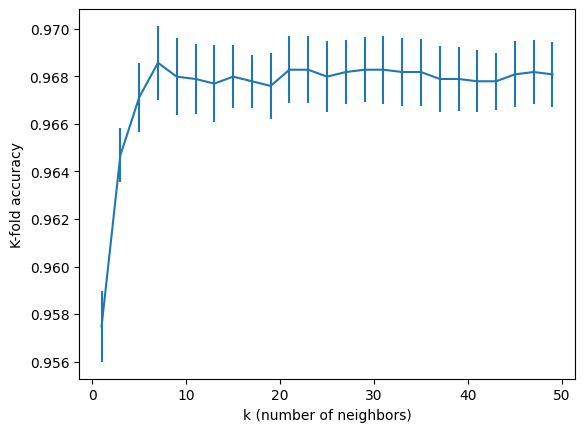

In [22]:
plt.errorbar(x=k_list, y=acc_list.mean(axis=1), yerr=acc_list.std(axis=1)/np.sqrt(n_fold-1));

plt.xlabel("k (number of neighbors)");
plt.ylabel("K-fold accuracy");

In [23]:
best_k = k_list[np.argmax(acc_list.mean(axis=1))]
print(best_k)

7


# Evaluation

Re-running the KNN algorithm using the entire training set and the `best_k` number of neighbors. Checking its accuracy on the test data.

In [24]:
distances_custom_test = np.zeros(shape=(len(idx_ts), len(idx_tr)))

for idx in tqdm(range(len(idx_ts)),  total=len(idx_ts), desc="Distance matrix"):
  distances_custom_test[idx] = custom_distance(X_trans.iloc[idx_ts[idx]].values, X_trans.iloc[idx_tr].values)

Distance matrix: 100%|██████████| 4406/4406 [03:50<00:00, 19.12it/s]


In [25]:
# generating a random matrix for tie breaking
r_matrix = np.random.random(size=(distances_custom_test.shape))

# for each pair of rows, returning best_k sorted indices
nn_lists = np.array([np.lexsort((r, row))[:best_k] for r, row in zip(r_matrix,distances_custom_test)])
nn_lists_idx = idx_tr[nn_lists]

# getting validation accuracy for this value of k
y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]
acc = accuracy_score(y.iloc[idx_ts], y_pred)
print(acc)

0.970494779845665
